In [1]:
import matplotlib.pyplot as plt
import numpy as np

import cs229_2018_autumn.problem_sets.PS1.src.util as util
from cs229_2018_autumn.problem_sets.PS1.src.linear_model import LinearModel

In [2]:
ds1_training_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds1_train.csv"
ds1_valid_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds1_valid.csv"
ds2_training_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds2_train.csv"
ds2_valid_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds2_valid.csv"

In [3]:
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=True)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=True)

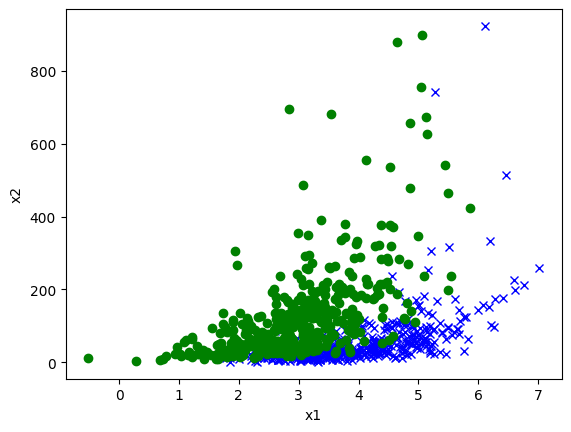

In [4]:
plt.xlabel("x1")
plt.ylabel("x2")
plt.plot(x_train[y_train == 1, -2], x_train[y_train == 1, -1], "bx", linewidth=2)
plt.plot(x_train[y_train == 0, -2], x_train[y_train == 0, -1], "go", linewidth=2)

In [5]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """

        # *** START CODE HERE ***
        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))

        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,)."""

            m, _ = x.shape
            return -1 / m * np.dot(x.T, (y - h(theta, x)))

        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """

            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))

            return 1 / m * np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)

        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.

            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """

            return theta - np.dot(
                np.linalg.inv(
                    hessian(
                        theta,
                        x,
                    )
                ),
                gradient(theta, x, y),
            )

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros(n)

        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)

        self.theta = new_theta

        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return x @ self.theta >= 0
        # *** END CODE HERE ***

In [6]:
# Train the logistic regression model:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

Theta is:  [-6.26018491  2.47707251 -0.0299125 ]
The accuracy on training set is:  0.8825


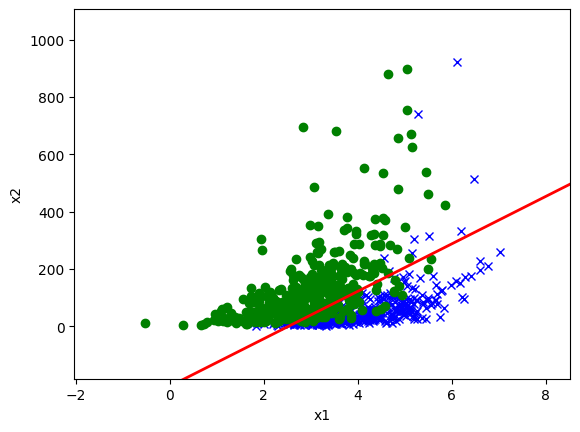

In [7]:
# Plot decision boundary for training set:
util.plot(x_train, y_train, theta=log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on training set is: ", np.mean(log_reg.predict(x_train) == y_train))

The accuracy on validation set is:  0.9


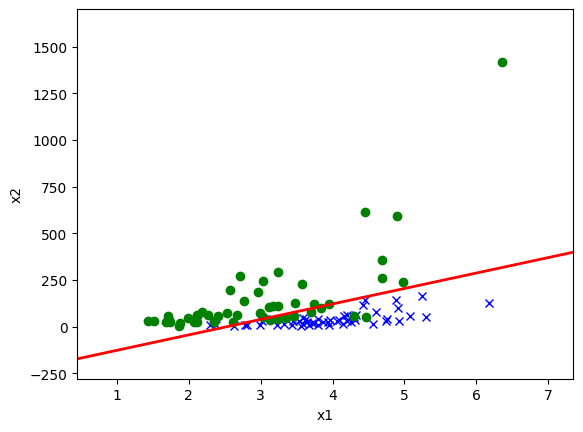

In [8]:
# Plot decision boundary for validation set:
util.plot(x_valid, y_valid, log_reg.theta)
print(
    "The accuracy on validation set is: ", np.mean(log_reg.predict(x_valid) == y_valid)
)

In [9]:
# Implement GDA
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***

        m, n = x.shape

        phi =  1/m * np.sum(y)
        mu_0 = np.dot(x.T, 1 - y) / np.sum(1 - y)
        mu_1 = np.dot(x.T, y) / np.sum(y)

        # Reshape to compute parawise product with mu
        y_reshaped = np.reshape(y, (m, -1))

        # Matrix comprises mu_0 and mu_1 based on the value of y. Shape(m, n)
        mu_x = y_reshaped * mu_1 + (1 - y_reshaped) * mu_0

        x_centered = x - mu_x

        sigma = np.dot(x_centered.T, x_centered) / m
        sigma_inv = np.linalg.inv(sigma)

        # Compute theta and theta_0 accorgingly to the conclusion form part (c)
        theta = np.dot(sigma_inv, mu_1 - mu_0)
        theta_0 = 1/2 * mu_0 @ sigma_inv @ mu_0 - 1/2 * mu_1 @ sigma_inv @ mu_1 - np.log((1 - phi) / phi)

        self.theta = np.insert(theta, 0, theta_0)


        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        # Add x_0 = 1 convention to make predictions using theta^T x >= 0
        
        return util.add_intercept(x) @ self.theta >= 0
    

        # *** END CODE HERE

In [10]:
x_train, y_train = util.load_dataset(ds1_training_set_path)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path)

In [11]:
gda = GDA()
gda.fit(x_train, y_train)

In [12]:
print("Theta is: ", gda.theta)
print("The accuracy on training set is: ", np.mean(gda.predict(x_train) == y_train))
print("The accuracy on validation set is: ", np.mean(gda.predict(x_valid) == y_valid))

Theta is:  [-6.17158405  2.22055506 -0.01763375]
The accuracy on training set is:  0.86625
The accuracy on validation set is:  0.83


In [13]:
def plot(x, y, theta_1, legend_1=None, theta_2=None, legend_2=None, title=None, correction=1.0):
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta_1^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta_1[0] / theta_1[2] * correction + theta_1[1] / theta_1[2] * x1)
    plt.plot(x1, x2, c='red', label=legend_1, linewidth=2)

    # Plot decision boundary (found by solving for theta_2^T x = 0)
    if theta_2 is not None:
        x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
        x2 = -(theta_2[0] / theta_1[2] * correction + theta_2[1] / theta_2[2] * x1)
        plt.plot(x1, x2, c='black', label=legend_2, linewidth=2)

    # Add labels, legend and title
    plt.xlabel('x1')
    plt.ylabel('x2')
    if legend_1 is not None or legend_2 is not None:
        plt.legend(loc="upper left")
    if title is not None:
        plt.suptitle(title, fontsize=12)

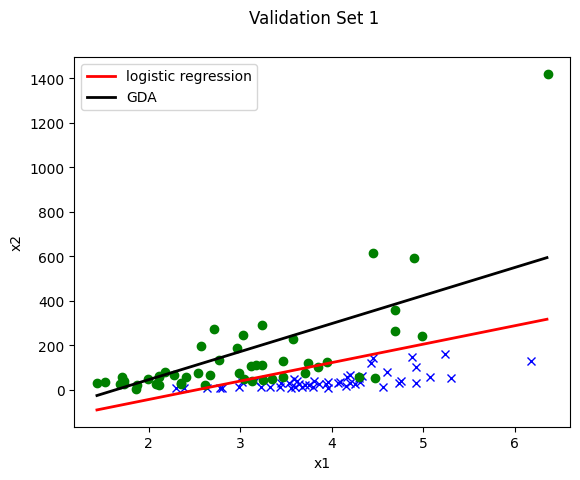

In [14]:
plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Validation Set 1')

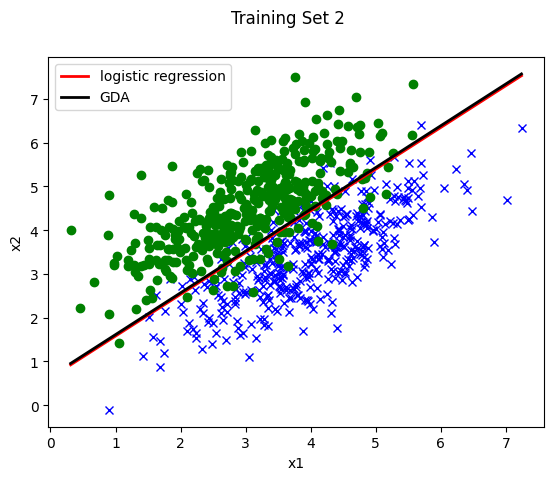

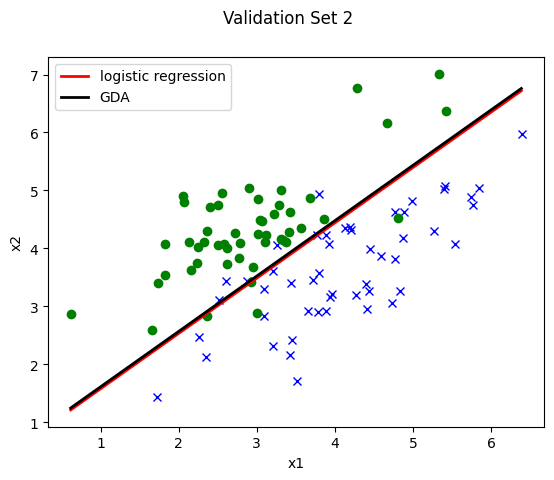

In [15]:
# Train logistic regression
x_train, y_train = util.load_dataset(ds2_training_set_path, add_intercept=True)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Train GDA
x_train, y_train = util.load_dataset(ds2_training_set_path)
gda = GDA()
gda.fit(x_train, y_train)

# Plot decision boundaries on training set 2
plot(x_train, y_train, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Training Set 2')

# Plot decision boundaries on validation set 2
x_valid, y_valid = util.load_dataset(ds2_valid_set_path)
plot(x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Validation Set 2')

GDA performs poorly on dataset 1 but OK on dataset 2. The reason is that GDA assumes p(x | y)
 is Gaussian, whereas dataset 1 is non-Gaussian.

Take a look at dataset 1, we find that all the 
x_2's are non-negative. Take the logarithm of 
x_2 and train the classifiers:

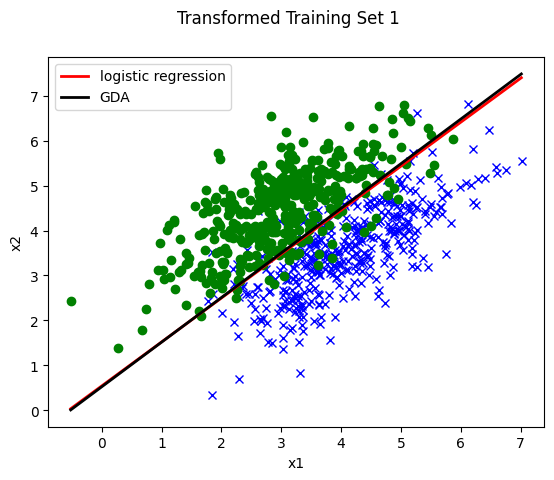

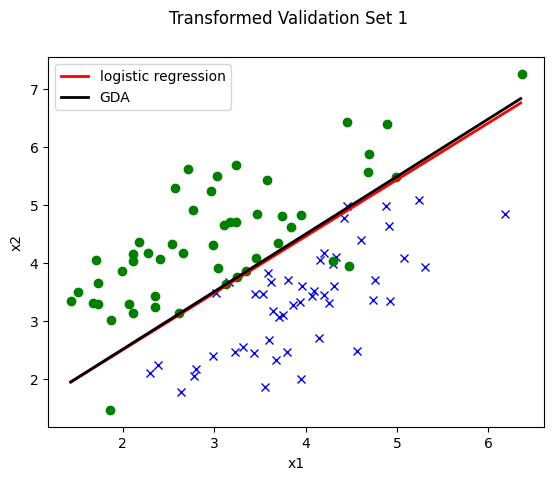

In [16]:
x_train, y_train = util.load_dataset(ds1_training_set_path)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path)
transformed_x_train = np.stack((x_train[:,0], np.log(x_train[:,1])), axis=1)
transformed_x_valid = np.stack((x_valid[:,0], np.log(x_valid[:,1])), axis=1)

# Train logistic regression
transformed_x_train_with_intercept = util.add_intercept(transformed_x_train)
log_reg = LogisticRegression()
log_reg.fit(transformed_x_train_with_intercept, y_train)

# Train GDA
gda = GDA()
gda.fit(transformed_x_train, y_train)

# Plot decision boundaries on training set 1
plot(transformed_x_train, y_train, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Transformed Training Set 1')

# Plot decision boundaries on validation set 1
plot(transformed_x_valid, y_valid, theta_1=log_reg.theta, legend_1='logistic regression', theta_2=gda.theta, legend_2='GDA', title='Transformed Validation Set 1')

In [20]:
# Ex 2 c.
ds3_training_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds3_train.csv"
ds3_valid_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds3_valid.csv"
ds3_test_set_path = "/teamspace/studios/this_studio/cs229_2018_autumn/problem_sets/PS1/data/ds3_test.csv"

x_train, y_train = util.load_dataset(ds3_training_set_path, add_intercept=True)
_, t_train = util.load_dataset(ds3_training_set_path, label_col='t')
x_valid, y_valid = util.load_dataset(ds3_valid_set_path, add_intercept=True)
_, t_valid = util.load_dataset(ds3_valid_set_path, label_col='t')
x_test, y_test = util.load_dataset(ds3_test_set_path, add_intercept=True)
_, t_test = util.load_dataset(ds3_test_set_path, label_col='t')

In [21]:
x_train

array([[ 1.        , -1.54831899, -2.76298744],
       [ 1.        , -3.95886967, -0.6127805 ],
       [ 1.        , -2.27637464,  0.61493359],
       ...,
       [ 1.        ,  1.10777214,  1.62589313],
       [ 1.        ,  1.46109326,  0.55889854],
       [ 1.        ,  0.93522112,  2.9003691 ]])

In [22]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
t_train

array([0., 0., 0., ..., 1., 1., 1.])

In [25]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        def h(theta, x):
            """Vectorized implementation of h_theta(x) = 1 / (1 + exp(-theta^T x)).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The hypothesis for all training examples. Shape (m,).
            """
            return 1 / (1 + np.exp(-np.dot(x, theta)))

        def gradient(theta, x, y):
            """Vectorized implementation of the gradient of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :param y:     All labels of shape (m,).
            :return:      The gradient of shape (n,).
            """
            m, _ = x.shape
            return -1 / m * np.dot(x.T, (y - h(theta, x)))

        def hessian(theta, x):
            """Vectorized implementation of the Hessian of J(theta).

            :param theta: Shape (n,).
            :param x:     All training examples of shape (m, n).
            :return:      The Hessian of shape (n, n).
            """
            m, _ = x.shape
            h_theta_x = np.reshape(h(theta, x), (-1, 1))
            return 1 / m * np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)

        def next_theta(theta, x, y):
            """The next theta updated by Newton's Method.

            :param theta: Shape (n,).
            :return:      The updated theta of shape (n,).
            """
            return theta - np.dot(np.linalg.inv(hessian(theta, x)), gradient(theta, x, y))

        m, n = x.shape

        # Initialize theta
        if self.theta is None:
            self.theta = np.zeros(n)

        # Update theta using Newton's Method
        old_theta = self.theta
        new_theta = next_theta(self.theta, x, y)
        while np.linalg.norm(new_theta - old_theta, 1) >= self.eps:
            old_theta = new_theta
            new_theta = next_theta(old_theta, x, y)

        self.theta = new_theta

    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """

        return x @ self.theta >= 0

In [26]:
log_reg = LogisticRegression()
log_reg.fit(x_train, t_train)

Theta is:  [-0.9711418   2.73208784  1.07403478]
The accuracy on training set is:  0.9632


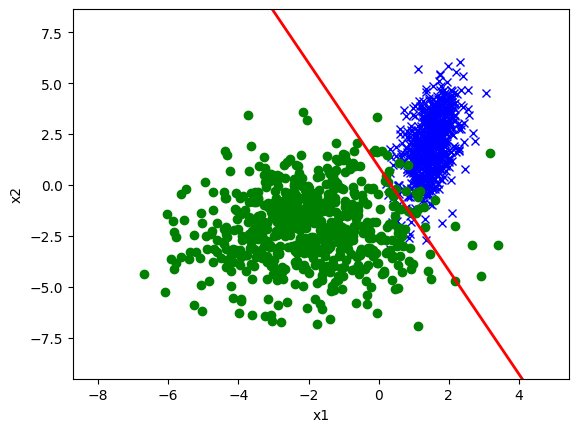

In [27]:
util.plot(x_train, t_train, log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on training set is: ", np.mean(t_train == log_reg.predict(x_train)))

Theta is:  [-0.9711418   2.73208784  1.07403478]
The accuracy on test set is:  0.9838709677419355


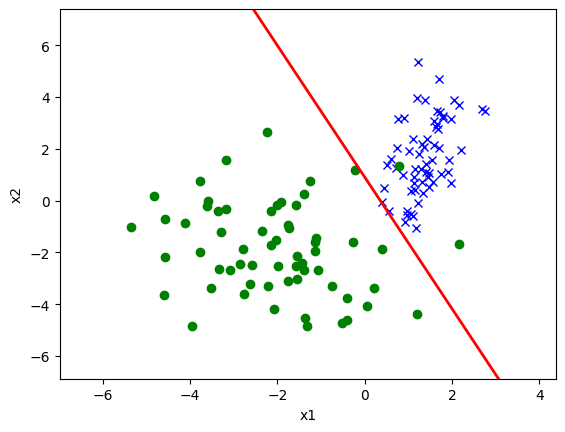

In [28]:
util.plot(x_test, t_test, log_reg.theta)
print("Theta is: ", log_reg.theta)
print("The accuracy on test set is: ", np.mean(t_test == log_reg.predict(x_test)))

In [29]:
# d - Assume the t-labels are unavailable, we then switch to y-labels for training:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

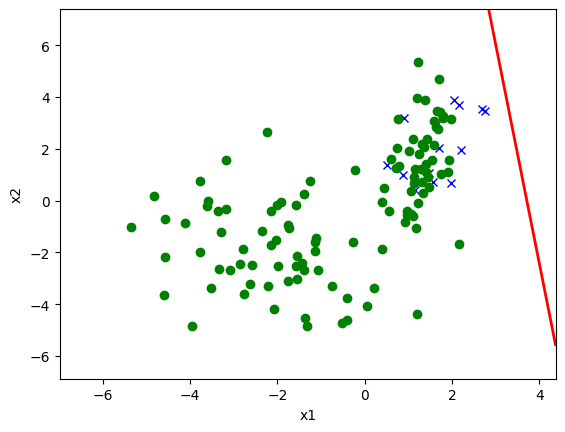

In [30]:
util.plot(x_test, y_test, log_reg.theta) # We expect it to perform poorly.

In [31]:
# e - Reuse function `h` in the logistic regression model:
def h(theta, x):
    return 1 / (1 + np.exp(-np.dot(x, theta)))

# And estimate alpha
v_plus = x_valid[y_valid == 1]
alpha = h(log_reg.theta, v_plus).mean()


# Rescale clasiffier predictions using alpha
def predict(theta, x):
    return h(theta, x) / alpha >= 0.5

In [32]:
theta_prime = log_reg.theta + np.log(2 / alpha - 1) * np.array([1, 0, 0])

Theta_prime is:  [-0.55096984  0.78596651  0.09282768]
The accuracy on test set is:  0.9516129032258065


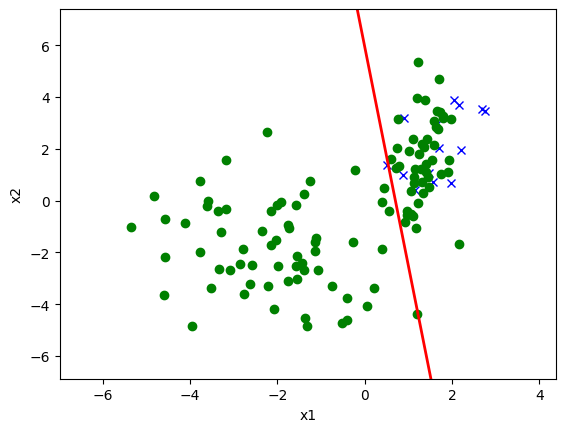

In [33]:
util.plot(x_test, y_test, theta_prime)
print("Theta_prime is: ", theta_prime)
print("The accuracy on test set is: ", np.mean(predict(log_reg.theta, x_test) == t_test))